### `Coulomb Eigenstates`
#### Rev. 4/3/2023.

In [1]:
'''
Calculate the eigenstates & eigen-energies of a soft-core Coulomb potential.

References
[1] D. T. Colbert and W. H. Miller, "A novel discrete variable representation
    for quantum mechanical reactive scattering via the S-matrix Kohn method",
    J. Chem. Phys. 96, 1982 (1992).
'''

import numpy as np
import scipy as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import rc

### A. 1D Cartesian or Radial Wavefunction

In [2]:
def calc_states1d(mode, Z, ap, r0, nr, k=10, sigma=-1.):
    '''
    --- required parameters ---
    mode [char]: 'C'/'R' for Cartesian/Radial
    Z [float, list]: [0] nuclear, [1] electronic charge (a.u.)
    ap [float]: atomic screening parameter (a.u.) (mode 'C')
        or OAM quantum number (l) (mode 'R')
    r0 [float]: domain spatial extent (a.u.)
    nr [int]: no. domain points
    --- optional parameters ---
    k [int]: no. eigenvalues/vectors to calculate
    sigma [float]: find eigenvalues near sigma
    '''
    # construct domain
    if (mode == 'C'): r = np.linspace(-r0, r0, nr); dr = r[1]-r[0];
    if (mode == 'R'): dr = r0/nr; r = np.linspace(dr, r0, nr);
    # construct Hamiltonian
    Tr = -2*np.eye(nr) + np.diag(np.ones(nr-1),+1) + np.diag(np.ones(nr-1),-1); Tr /= -2*(dr**2);
    if (mode == 'C'): V = np.diag(Z[0]*Z[1]/np.sqrt(r**2 + ap**2))
    if (mode == 'R'): V = np.diag(Z[0]*Z[1]/r) + ap*(ap+1)/2./(r**2)
    H = sp.sparse.csr_matrix(Tr+V)
    # diagonalize Hamiltonian
    wn,psi = sp.sparse.linalg.eigs(H, k=k, sigma=sigma)
    # normalize eigenstates
    for i in range(k): psi[:,i] /= np.sqrt(dr*np.trapz(abs(psi[:,i])**2))
    # done
    return wn, psi, r

def view1d(e,f,r,n,lims=None):
    '''
    input: eigenvalue (e), eigenvector (f), position (r) arrays and level index (n) to view
    optional: view limits (lims) [min,max]
    '''
    # plot settings
    font = {'size':10,'weight':'normal'}; dpi = 100; rc('font',**font);
    fig, ax = plt.subplots(1,2, figsize=(7.5,3), dpi=dpi, facecolor='w')
    plt.subplots_adjust(hspace=0.0)
    ax_01 = ax[0].twinx()
    
    ax[0].set_title(r'$n = '+str(n)+'$, $E={}$ a.u.'
        .format(str(np.round(wn[n].real,3))), size=font['size'])
    
    ax[0].plot(r, f[:,n].real, 'b', lw=1.5)
    ax_01.plot(r, abs(f[:,n])**2, 'tab:red', lw=1.5)
    ax[0].set_xlim(lims)
    
    ax[0].tick_params(axis='y', labelcolor='b')
    ax_01.tick_params(axis='y', labelcolor='tab:red')
    ax[0].set_xlabel(r'Position, r (a.u.)')
    ax[0].set_ylabel(r'Wavefunction, ${\rm Re}\,\psi(r)$', c='b')
    ax_01.set_ylabel(r'Probability density, $|\psi(r)|^2$', c='tab:red')
    
    for i in range(len(e)):
        ax[1].plot([-0.25,0.25], [e[i].real,e[i].real], c='k', lw=1.0)
    ax[1].set_ylabel(r'Energy (a.u.)')
    ax[1].set_aspect(10.); ax[1].set_xticks([]);
    ax[1].tick_params(which='both', direction='in')
    ax[1].spines[['bottom','right','top']].set_visible(False)
    plt.show()

#### A.1. Evaluation: 1D Cartesian Wavefunction

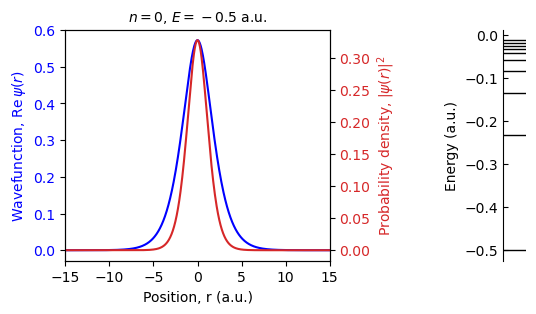

In [3]:
wn, psi, r = calc_states1d('C', [+1,-1], np.sqrt(2.), 50., 2048, k=10, sigma=-1.)
view1d(wn,psi,r, 0, [-15,15])

#### A.2. Evaluation: 1D Radial Wavefunction

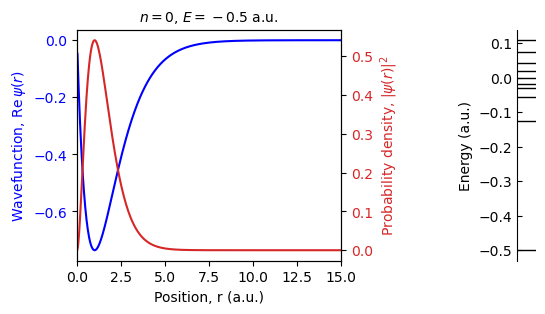

In [4]:
wn, psi, r = calc_states1d('R', [+1,-1], 0, 50., 2048, k=10, sigma=-1.)
view1d(wn,psi,r, 0, [0,15])

### B. 2D Cartesian Wavefunction

In [5]:
def calc_states2d(Z, ap, r0, nr, k=10, sigma=-3.0):
    '''
    --- required parameters ---
    Z [float, list]: [0] nuclear, [1:2] electronic charges (a.u.)
    ap [float, list]: atomic screening parameters (a.u.)
        ap[0,1,2] for [e1-n, e2-n, e1-e2] potentials
    r0 [float, list]: domain spatial extent in [x,y] (a.u.)
    nr [int, list]: no. domain points in [x,y]
    --- optional parameters ---
    k [int]: no. eigenvalues/vectors to calculate
    sigma [float]: find eigenvalues near sigma
    '''
    # construct domain
    x = np.linspace(-r0[0], r0[0], nr[0]); dx = x[1]-x[0];
    y = np.linspace(-r0[1], r0[1], nr[1]); dy = y[1]-y[0];
    xx,yy = np.meshgrid(*(x,y), indexing='ij')
    i,ip = np.meshgrid(*(np.arange(nr[0], dtype=float) for _ in range(2)), indexing='ij')
    j,jp = np.meshgrid(*(np.arange(nr[1], dtype=float) for _ in range(2)), indexing='ij')
    # construct Hamiltonian
    V = np.reshape(\
          Z[0]*Z[1]/np.sqrt(ap[0]**2 + xx**2) \
        + Z[0]*Z[2]/np.sqrt(ap[1]**2 + yy**2) \
        + Z[1]*Z[2]/np.sqrt(ap[2]**2 + (xx-yy)**2), nr[0]*nr[1])
    Tx = np.divide((-1.)**(i-ip), (dx**2)*(i-ip)**2, \
        out=np.zeros_like(i), where=(i-ip)!=0.)
    Tx += np.diag((np.pi**2)/(dx**2)/6. * np.ones(nr[0]))
    Ty = np.divide((-1.)**(j-jp), (dy**2)*(j-jp)**2, \
        out=np.zeros_like(j), where=(j-jp)!=0.)
    Ty += np.diag((np.pi**2)/(dy**2)/6. * np.ones(nr[1]))
    H = sp.sparse.csr_matrix(np.diag(V) + np.kron(Tx,np.eye(nr[1])) + np.kron(np.eye(nr[0]),Ty))
    # diagonalize Hamiltonian
    wn,psi_t = sp.sparse.linalg.eigs(H, k=k, sigma=sigma)
    # normalize eigenstates
    psi = np.zeros((nr[1],nr[0],k), dtype=complex)
    for i in range(k):
        psi[:,:,i] = psi_t[:,i].reshape((nr[1],nr[0]))
        psi[:,:,i] /= np.sqrt(dx*dy*np.trapz(np.trapz(abs(psi[:,:,i])**2)))
    # done
    return wn, psi, V.reshape((nr[1],nr[0])), x, y

#### B.2. Evaluation: 2D Cartesian Wavefunction

In [6]:
wn, psi, V, x, y = calc_states2d([+2,-1,-1], [1.,1.,1.], [10.,10.], [75,75], k=3, sigma=-3.)

In [7]:
wn

array([-2.23825782+0.j, -1.81604955+0.j, -1.70425914+0.j])